# Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_auc_score

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Initialise GPU

In [2]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data Loading and Pre-processing

In [3]:
class MIMICDataProcessor:
    def __init__(self, file_path, batch_size=64):
        self.file_path = file_path
        self.batch_size = batch_size
        self.scaler = StandardScaler()

        # Load and preprocess the data
        self.df = pd.read_csv(file_path)

        # Replace all missing values with 0
        self.df.fillna(0, inplace=True)

        # Features
        self.X = self.df[['upper_respiratory_infections', 'influenza_pneumonia', 'acute_lower_respiratory_infections', 'chronic_lower_respiratory_diseases',
                          'lung_diseases_due_to_external_agents', 'other_respiratory_diseases', 'InvasiveVent', 'SupplementalOxygen', 'HFNC',
                          'NonInvasiveVent', 'Tracheostomy', 'None', 'avg_uo_24hr', 'avg_creatinine_max', 'max_renal_uo_24hr', 'max_renal_creatinine_max',
                          'avg_pao2fio2ratio_novent', 'avg_pao2fio2ratio_vent', 'max_respiration_pao2fio2ratio_novent', 'max_respiration_pao2fio2ratio_vent', 'avg_gcs_min', 'max_cns_gcs_min',
                          'sofa_score', 'suspected_infection', 'one_vasopressor', 'multi_vasopressor']]

        # Vanilla Concepts
        self.C = self.df[['c_rsp_mod', 'c_rsp_svr', 'c_vent_low', 'c_vent_moderate', 'c_vent_high', 'c_max_renf_moderate', 'c_max_renf_severe',
                          'c_avg_renf_moderate', 'c_avg_renf_severe', 'c_max_respf_moderate', 'c_max_respf_severe', 'c_avg_respf_moderate',
                          'c_avg_respf_severe', 'c_max_cnsf_moderate', 'c_max_cnsf_severe', 'c_avg_cnsf_moderate', 'c_avg_cnsf_severe',
                          'c_sepsis3', 'c_shock']]

        # Additional LLM Concepts
        self.LLM_C = self.df[['ards_detected', 'aspiration_detected', 'bilateral_infiltrates_detected', 'cardiac_arrest_detected',
                          'cardiac_failure_detected', 'pancreatitis_detected', 'pneumonia_detected', 'trali_detected']]

        # Label
        self.Y = self.df['ARDS']

        # Convert to tensors
        self.X_tensor = torch.tensor(self.X.values, dtype=torch.float32)
        self.C_tensor = torch.tensor(self.C.values, dtype=torch.float32)
        self.LLM_C_tensor = torch.tensor(self.LLM_C.values, dtype=torch.float32)
        self.Y_tensor = torch.tensor(self.Y.values, dtype=torch.float32)

        # Normalize the features
        self.X_scaled = self.scaler.fit_transform(self.X)
        self.X_tensor_scaled = torch.tensor(self.X_scaled, dtype=torch.float32)

    def get_features(self):
        return self.X.columns.tolist()

    def get_vanilla_concepts(self):
        return self.C.columns.tolist()

    def get_llm_concepts(self):
        return self.LLM_C.columns.tolist()

    class MIMICDataset(Dataset):
        def __init__(self, x, c, llm_c, y):
            self.x = x
            self.c = c
            self.llm_c = llm_c
            self.y = y

        def __len__(self):
            return len(self.y)

        def __getitem__(self, idx):
            return self.x[idx], self.c[idx], self.llm_c[idx], self.y[idx]


    def create_dataloaders(self):
        # Split the data into temporary (80%) and test (20%) sets
        X_temp, X_test, C_temp, C_test, LLM_C_temp, LLM_C_test, Y_temp, Y_test = train_test_split(
            self.X_tensor_scaled, self.C_tensor, self.LLM_C_tensor, self.Y_tensor, test_size=0.20, random_state=42)

        # Further split the temporary data into training (75% of temporary) and validation (25% of temporary) sets
        X_train, X_val, C_train, C_val, LLM_C_train, LLM_C_val, Y_train, Y_val = train_test_split(
            X_temp, C_temp, LLM_C_temp, Y_temp, test_size=0.25, random_state=42)

        train_dataset = self.MIMICDataset(X_train, C_train, LLM_C_train, Y_train)
        val_dataset = self.MIMICDataset(X_val, C_val, LLM_C_val, Y_val)
        test_dataset = self.MIMICDataset(X_test, C_test, LLM_C_test, Y_test)

        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False)

        return train_loader, val_loader, test_loader

# Model

In [4]:
class MultiLabelNN(nn.Module):
    def __init__(self, num_features, num_labels):
        super(MultiLabelNN, self).__init__()
        self.layer1 = nn.Linear(num_features, 64)
        self.layer2 = nn.Linear(64, 128)
        self.layer3 = nn.Linear(128, 64)
        self.output_layer = nn.Linear(64, num_labels)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        x = torch.sigmoid(self.output_layer(x))  # Sigmoid activation to output probabilities for each label
        return x

class CombinedNN(nn.Module):
    def __init__(self, num_features, num_vanilla_concepts, num_llm_concepts, num_labels):
        super(CombinedNN, self).__init__()
        self.vanilla_c_predictor = MultiLabelNN(num_features, num_vanilla_concepts)
        self.label_predictor = MultiLabelNN(num_vanilla_concepts + num_llm_concepts, num_labels)

    def forward(self, x, vanilla_c, llm_c):
        vanilla_c_pred = self.vanilla_c_predictor(x)
        combined_c = torch.cat((vanilla_c, llm_c), dim=1) # Independent because it doesn't take in the predictions
        y_pred = self.label_predictor(combined_c)
        return y_pred, vanilla_c_pred

# Training

In [5]:
def train_combined_model(x_size, vanilla_c_size, llm_c_size, y_size, learning_rate, epochs, train_loader, val_loader, weight_decay=0.01):
    torch.manual_seed(25)

    model = CombinedNN(num_features=x_size, num_vanilla_concepts=vanilla_c_size, num_llm_concepts=llm_c_size, num_labels=y_size).to(device)

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

    epochs_count = []
    train_loss_values, val_loss_values = [], []
    vanilla_c_predictions, label_predictions = [], []
    vanilla_c_val_predictions, label_val_predictions = [], []
    ground_truth_val_vanilla_c, ground_truth_val_label = [], []

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")  # Print current epoch
        epochs_count.append(epoch)

        # Training Loop
        model.train()
        running_loss = 0.0

        for i, batch in enumerate(train_loader):
            x, vanilla_c, llm_c, y = batch
            x, vanilla_c, llm_c, y = x.to(device), vanilla_c.to(device), llm_c.to(device), y.to(device)

            # Forward pass
            optimizer.zero_grad()
            y_pred, vanilla_c_pred = model(x, vanilla_c, llm_c)
            vanilla_c_predictions.append(vanilla_c_pred.detach().cpu().numpy())
            label_predictions.append(y_pred.detach().cpu().numpy())
            loss = criterion(y_pred, y.unsqueeze(1).float())

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Accumulate loss value
            running_loss += loss.item()

        train_loss_values.append(running_loss / len(train_loader))

        # Validation Loop
        model.eval()
        running_val_loss = 0.0

        with torch.no_grad():
            for x, vanilla_c, llm_c, y in val_loader:
                x, vanilla_c, llm_c, y = x.to(device), vanilla_c.to(device), llm_c.to(device), y.to(device)

                ground_truth_val_vanilla_c.append(vanilla_c.cpu())
                ground_truth_val_label.append(y.cpu())

                # Forward pass through model
                y_pred, vanilla_c_pred = model(x, vanilla_c, llm_c)
                vanilla_c_val_predictions.append(vanilla_c_pred.detach().cpu().numpy())
                label_val_predictions.append(y_pred.detach().cpu().numpy())
                loss = criterion(y_pred, y.unsqueeze(1).float())

                # Accumulate loss value
                running_val_loss += loss.item()

        val_loss_values.append(running_val_loss / len(val_loader))

        scheduler.step()

    return model, epochs_count, train_loss_values, val_loss_values, vanilla_c_predictions, label_predictions, vanilla_c_val_predictions, label_val_predictions, ground_truth_val_vanilla_c, ground_truth_val_label

In [6]:
# Specify Parameters
x_size = 26
vanilla_c_size = 19
llm_c_size = 8
y_size = 1
learning_rate = 0.01
epochs = 60
weight_decay = 0.01

# Load Data
file_path = '/content/augmented-ards-data.csv'
data_processor = MIMICDataProcessor(file_path, batch_size=64)
train_loader, val_loader, test_loader = data_processor.create_dataloaders()

regularised_model, epochs_count, train_loss_values, val_loss_values, vanilla_c_predictions, label_predictions, vanilla_c_val_predictions, label_val_predictions, ground_truth_val_vanilla_c, ground_truth_val_label = train_combined_model(x_size, vanilla_c_size, llm_c_size, y_size, learning_rate, epochs, train_loader, val_loader, weight_decay)

Epoch 1/60
Epoch 2/60
Epoch 3/60
Epoch 4/60
Epoch 5/60
Epoch 6/60
Epoch 7/60
Epoch 8/60
Epoch 9/60
Epoch 10/60
Epoch 11/60
Epoch 12/60
Epoch 13/60
Epoch 14/60
Epoch 15/60
Epoch 16/60
Epoch 17/60
Epoch 18/60
Epoch 19/60
Epoch 20/60
Epoch 21/60
Epoch 22/60
Epoch 23/60
Epoch 24/60
Epoch 25/60
Epoch 26/60
Epoch 27/60
Epoch 28/60
Epoch 29/60
Epoch 30/60
Epoch 31/60
Epoch 32/60
Epoch 33/60
Epoch 34/60
Epoch 35/60
Epoch 36/60
Epoch 37/60
Epoch 38/60
Epoch 39/60
Epoch 40/60
Epoch 41/60
Epoch 42/60
Epoch 43/60
Epoch 44/60
Epoch 45/60
Epoch 46/60
Epoch 47/60
Epoch 48/60
Epoch 49/60
Epoch 50/60
Epoch 51/60
Epoch 52/60
Epoch 53/60
Epoch 54/60
Epoch 55/60
Epoch 56/60
Epoch 57/60
Epoch 58/60
Epoch 59/60
Epoch 60/60


# Plotting Loss


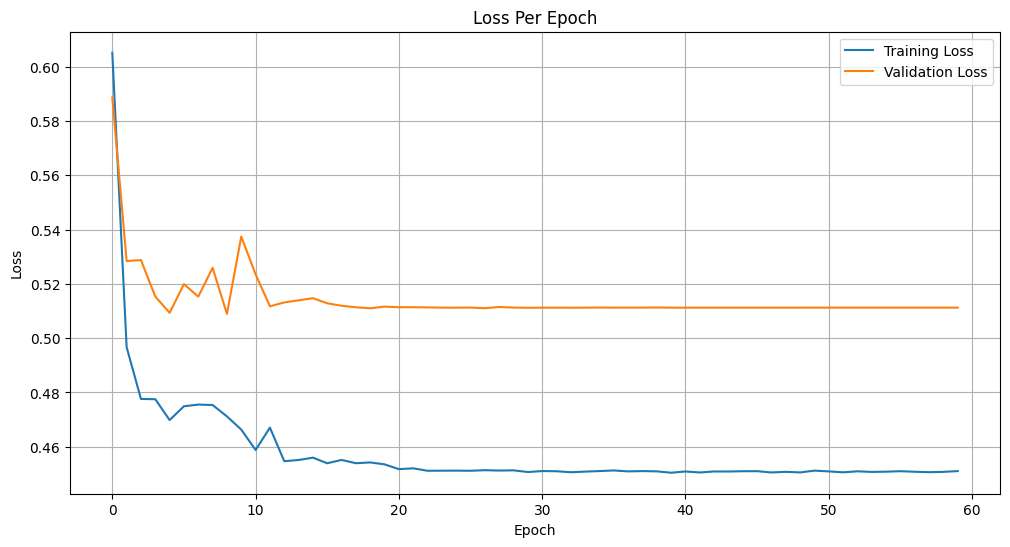

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(epochs_count, train_loss_values, label='Training Loss')
plt.plot(epochs_count, val_loss_values, label='Validation Loss')
plt.title('Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Completeness Score

In [8]:
from sklearn.metrics import mutual_info_score
import numpy as np

def compute_mutual_information(true_labels, predicted_values):
    # Convert the predicted values to binary classes
    predicted_classes = (predicted_values > 0.5).astype(int)
    return mutual_info_score(true_labels, predicted_classes)

# Compute mutual information I(y; c)
def compute_I_y_c(ground_truth_val_y, c_to_y_val_predictions):
    true_values = np.concatenate([gy.numpy() for gy in ground_truth_val_y])
    predicted_values = np.concatenate([py.squeeze() for py in c_to_y_val_predictions])
    return compute_mutual_information(true_values, predicted_values)

# Compute mutual information I(y; c, x)
def compute_I_y_c_x(ground_truth_val_y, x_to_c_val_predictions, c_to_y_val_predictions):
    true_values = np.concatenate([gy.numpy() for gy in ground_truth_val_y])

    # Compute mutual information for each concept and label pair
    predicted_concepts = np.concatenate(x_to_c_val_predictions)
    predicted_labels = np.concatenate([py.squeeze() for py in c_to_y_val_predictions])

    combined_predictions = np.column_stack((predicted_concepts, predicted_labels))

    # Flatten combined_predictions to make it 1D
    combined_predictions_flat = combined_predictions.flatten()

    return mutual_info_score(true_values, combined_predictions_flat[:len(true_values)])

# Compute the Completeness Score
def compute_completeness_score(I_y_c, I_y_c_x):
    return I_y_c / I_y_c_x

# Calculate mutual information
I_y_c = compute_I_y_c(ground_truth_val_label, label_val_predictions)
print(f"Mutual Information I(y; c): {I_y_c}")

I_y_c_x = compute_I_y_c_x(ground_truth_val_label, vanilla_c_val_predictions, label_val_predictions)
print(f"Mutual Information I(y; c, x): {I_y_c_x}")

# Calculate completeness score
completeness_score = compute_completeness_score(I_y_c, I_y_c_x)
print(f"Completeness Score: {completeness_score}")


Mutual Information I(y; c): 0.12595099501118392
Mutual Information I(y; c, x): 0.683272888760149
Completeness Score: 0.1843348347096453


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received binary values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


# Validation Evaluation

In [9]:
# Concept Predictor Evaluation
def evaluate_concept_predictor(ground_truth_c, predicted_c, concept_labels):
    results = []
    for i, label in enumerate(concept_labels):
        true_values = np.concatenate([c[:, i] for c in ground_truth_c])
        predicted_values = np.concatenate([c[:, i] for c in predicted_c])

        predicted_classes = (predicted_values > 0.5).astype(int)

        precision = precision_score(true_values, predicted_classes, zero_division=0)
        recall = recall_score(true_values, predicted_classes, zero_division=0)
        f1 = f1_score(true_values, predicted_classes, zero_division=0)
        accuracy = accuracy_score(true_values, predicted_classes)

        results.append({
            "Label": label,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1,
            "Accuracy": accuracy
        })
    return pd.DataFrame(results)

# Label Predictor Evaluation
def evaluate_label_predictor(ground_truth_y, predicted_y):
    true_values = np.concatenate(ground_truth_y)
    predicted_values = np.concatenate(predicted_y).squeeze()

    predicted_classes = (predicted_values > 0.5).astype(int)

    precision = precision_score(true_values, predicted_classes)
    recall = recall_score(true_values, predicted_classes)
    f1 = f1_score(true_values, predicted_classes)
    auc = roc_auc_score(true_values, predicted_classes)
    accuracy = accuracy_score(true_values, predicted_classes)

    results = {
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "AUC": auc,
        "Accuracy": accuracy
    }
    return pd.DataFrame(results, index=["Metrics"])

In [10]:
# Evaluate the concept predictor
vanilla_concept_list = data_processor.C.columns.tolist()
concept_test_results = evaluate_concept_predictor(ground_truth_val_vanilla_c, vanilla_c_val_predictions, vanilla_concept_list)
print("\nValidation Concept Predictor Results:")
print(concept_test_results)

# Evaluate the label predictor
label_test_results = evaluate_label_predictor(ground_truth_val_label, label_val_predictions)
print("\nValidation Label Predictor Results:")
print(label_test_results)


Validation Concept Predictor Results:
                   Label  Precision    Recall  F1 Score  Accuracy
0              c_rsp_mod   0.698795  0.555911  0.619217  0.470297
1              c_rsp_svr   0.186104  0.986842  0.313152  0.185644
2             c_vent_low   0.765743  0.980645  0.859972  0.754950
3        c_vent_moderate   0.000000  0.000000  0.000000  0.868812
4            c_vent_high   1.000000  0.029777  0.057831  0.032178
5    c_max_renf_moderate   0.305556  0.661654  0.418052  0.393564
6      c_max_renf_severe   0.434783  0.612245  0.508475  0.425743
7    c_avg_renf_moderate   0.109726  1.000000  0.197753  0.116337
8      c_avg_renf_severe   0.138614  1.000000  0.243478  0.138614
9   c_max_respf_moderate   0.600000  0.176471  0.272727  0.960396
10    c_max_respf_severe   0.555556  0.012920  0.025253  0.044554
11  c_avg_respf_moderate   0.000000  0.000000  0.000000  0.725248
12    c_avg_respf_severe   0.000000  0.000000  0.000000  0.279703
13   c_max_cnsf_moderate   0.349010  

# Testing Evaluation

In [11]:
# Function to test the model and gather predictions
def test_combined_model(model, test_loader):
    model.eval()
    criterion = nn.BCELoss()

    running_loss = 0.0
    all_y_true = []
    all_y_pred = []
    all_vanilla_c_true = []
    all_vanilla_c_pred = []

    with torch.no_grad():
        for x, vanilla_c, llm_c, y in test_loader:
            x, vanilla_c, llm_c, y = x.to(device), vanilla_c.to(device), llm_c.to(device), y.to(device)

            y_pred, vanilla_c_pred = model(x, vanilla_c, llm_c)
            loss = criterion(y_pred, y.unsqueeze(1).float())
            running_loss += loss.item()

            all_y_true.append(y.cpu().numpy())
            all_y_pred.append(y_pred.cpu().numpy())
            all_vanilla_c_true.append(vanilla_c.cpu().numpy())
            all_vanilla_c_pred.append(vanilla_c_pred.cpu().numpy())

    average_loss = running_loss / len(test_loader)
    print(f'Test Loss: {average_loss:.4f}')

    return all_y_true, all_y_pred, all_vanilla_c_true, all_vanilla_c_pred

In [12]:
# Test the model and gather predictions
y_true, y_pred, vanilla_c_true, vanilla_c_pred = test_combined_model(regularised_model, test_loader)

# Evaluate the concept predictor
concept_labels = data_processor.C.columns.tolist()
concept_test_results = evaluate_concept_predictor(vanilla_c_true, vanilla_c_pred, concept_labels)
print("\nTest Concept Predictor Results:")
print(concept_test_results)

# Evaluate the label predictor
label_test_results = evaluate_label_predictor(y_true, y_pred)
print("\nTest Label Predictor Results:")
print(label_test_results)

Test Loss: 0.5475

Test Concept Predictor Results:
                   Label  Precision    Recall  F1 Score  Accuracy
0              c_rsp_mod   0.679389  0.587459  0.630088  0.483951
1              c_rsp_svr   0.202469  1.000000  0.336756  0.202469
2             c_vent_low   0.732997  0.976510  0.837410  0.720988
3        c_vent_moderate   0.000000  0.000000  0.000000  0.859259
4            c_vent_high   1.000000  0.019851  0.038929  0.024691
5    c_max_renf_moderate   0.323843  0.684211  0.439614  0.427160
6      c_max_renf_severe   0.384615  0.540541  0.449438  0.395062
7    c_avg_renf_moderate   0.069825  1.000000  0.130536  0.079012
8      c_avg_renf_severe   0.123457  1.000000  0.219780  0.123457
9   c_max_respf_moderate   0.714286  0.250000  0.370370  0.958025
10    c_max_respf_severe   0.428571  0.015584  0.030075  0.044444
11  c_avg_respf_moderate   0.000000  0.000000  0.000000  0.760494
12    c_avg_respf_severe   0.000000  0.000000  0.000000  0.239506
13   c_max_cnsf_moderate 

# Model Weights

In [13]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Function to get weights contribution from each feature to each concept
def get_feature_to_concept_weights(model, feature_names, concept_names):
    layer1_weights = model.vanilla_c_predictor.layer1.weight.data.cpu().numpy()
    contributions = np.zeros((len(concept_names), len(feature_names)))

    for i, feature in enumerate(feature_names):
        for j, concept in enumerate(concept_names):
            contributions[j, i] = layer1_weights[j, i]

    return pd.DataFrame(contributions, index=concept_names, columns=feature_names)

# Function to get weights contribution from each concept to final label
def get_concept_to_label_weights(model, concept_names, label_names):
    output_weights = model.label_predictor.output_layer.weight.data.cpu().numpy()
    contributions = np.zeros((len(label_names), len(concept_names)))

    for i, concept in enumerate(concept_names):
        for j, label in enumerate(label_names):
            contributions[j, i] = output_weights[j, i]

    return pd.DataFrame(contributions, index=label_names, columns=concept_names)


# Get feature and concept names
feature_names = data_processor.get_features()
vanilla_concepts = data_processor.get_vanilla_concepts()
llm_concepts = data_processor.get_llm_concepts()
all_concepts = vanilla_concepts + llm_concepts
label_names = ['ARDS']

# Get weights contributions
feature_to_concept_contributions = get_feature_to_concept_weights(regularised_model, feature_names, vanilla_concepts)
concept_to_label_contributions = get_concept_to_label_weights(regularised_model, all_concepts, label_names)

A. Feature to Concept

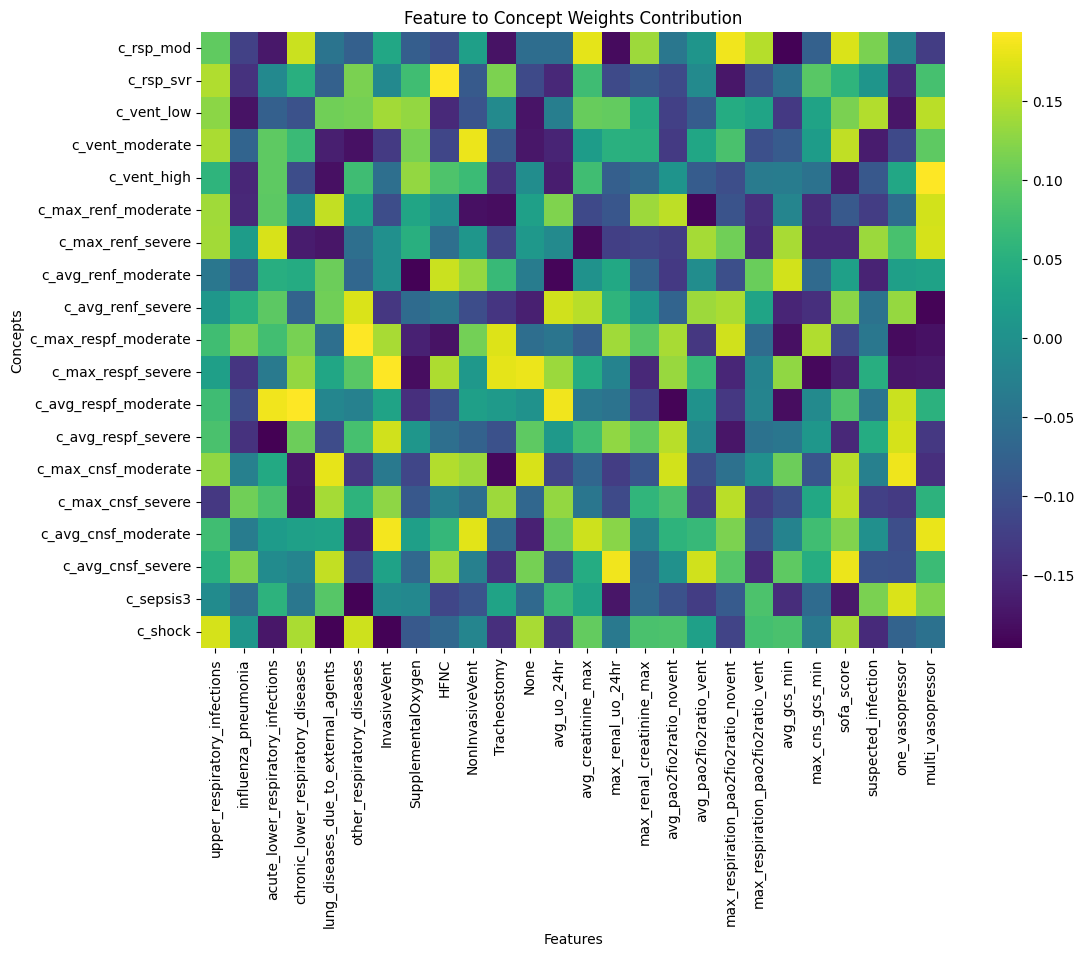

Feature to Concept Weights Contribution:
                      upper_respiratory_infections  influenza_pneumonia  \
c_rsp_mod                                 0.098755            -0.120458   
c_rsp_svr                                 0.146675            -0.140237   
c_vent_low                                0.125177            -0.176980   
c_vent_moderate                           0.143470            -0.071446   
c_vent_high                               0.057271            -0.154851   
c_max_renf_moderate                       0.137359            -0.152261   
c_max_renf_severe                         0.138716             0.018181   
c_avg_renf_moderate                      -0.041068            -0.090040   
c_avg_renf_severe                         0.009584             0.050689   
c_max_respf_moderate                      0.074133             0.116695   
c_max_respf_severe                        0.022159            -0.136645   
c_avg_respf_moderate                      0.072865         

In [14]:
plt.figure(figsize=(12, 8))
sns.heatmap(feature_to_concept_contributions, cmap='viridis', cbar=True)
plt.title('Feature to Concept Weights Contribution')
plt.xlabel('Features')
plt.ylabel('Concepts')
plt.show()

print("Feature to Concept Weights Contribution:")
print(feature_to_concept_contributions)

B. Concept to Label

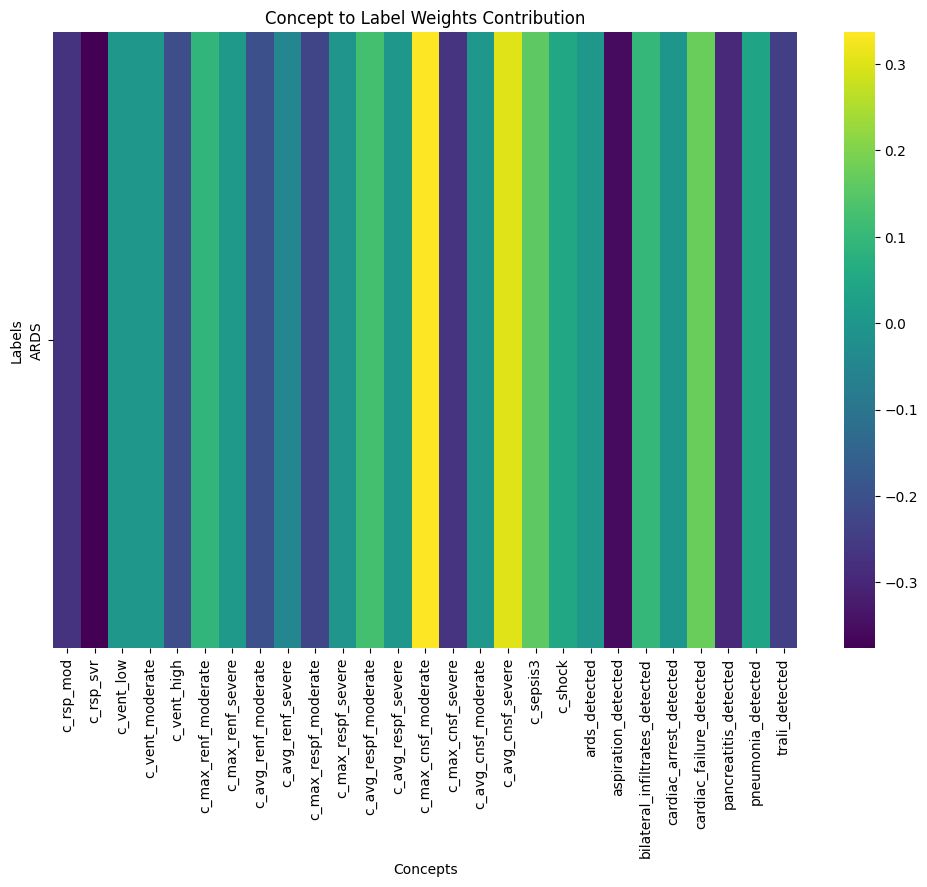

Concept to Label Weights Contribution:
      c_rsp_mod  c_rsp_svr  c_vent_low  c_vent_moderate  c_vent_high  \
ARDS  -0.270251  -0.376097    0.000046         0.000759    -0.206282   

      c_max_renf_moderate  c_max_renf_severe  c_avg_renf_moderate  \
ARDS             0.089489           0.010253            -0.202052   

      c_avg_renf_severe  c_max_respf_moderate  ...  c_sepsis3   c_shock  \
ARDS          -0.047947             -0.230579  ...   0.160986  0.048276   

      ards_detected  aspiration_detected  bilateral_infiltrates_detected  \
ARDS       0.000333            -0.356573                        0.098068   

      cardiac_arrest_detected  cardiac_failure_detected  \
ARDS                -0.002724                  0.173474   

      pancreatitis_detected  pneumonia_detected  trali_detected  
ARDS              -0.297613            0.040083       -0.242561  

[1 rows x 27 columns]


In [15]:
plt.figure(figsize=(12, 8))
sns.heatmap(concept_to_label_contributions, cmap='viridis', cbar=True)
plt.title('Concept to Label Weights Contribution')
plt.xlabel('Concepts')
plt.ylabel('Labels')
plt.show()

print("Concept to Label Weights Contribution:")
print(concept_to_label_contributions)

C. Combined Vanilla Feature - Vanilla Concept Pair to Label

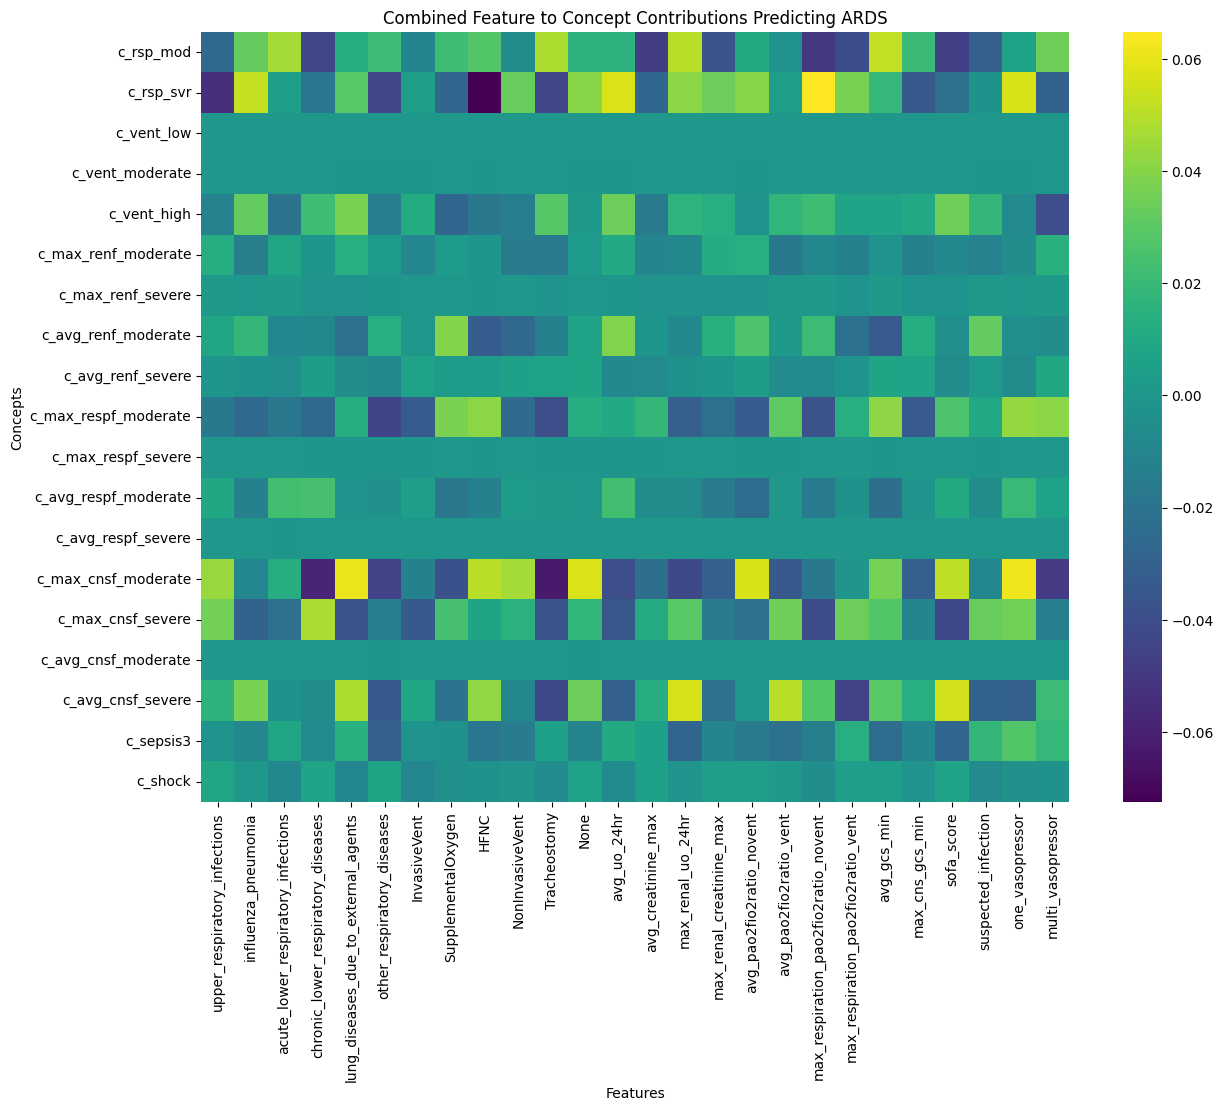

Combined Contributions Predicting ARDS:
                      upper_respiratory_infections  influenza_pneumonia  \
c_rsp_mod                                -0.026689             0.032554   
c_rsp_svr                                -0.055164             0.052743   
c_vent_low                                0.000006            -0.000008   
c_vent_moderate                           0.000109            -0.000054   
c_vent_high                              -0.011814             0.031943   
c_max_renf_moderate                       0.012292            -0.013626   
c_max_renf_severe                         0.001422             0.000186   
c_avg_renf_moderate                       0.008298             0.018193   
c_avg_renf_severe                        -0.000460            -0.002430   
c_max_respf_moderate                     -0.017093            -0.026907   
c_max_respf_severe                       -0.000068             0.000422   
c_avg_respf_moderate                      0.009115          

In [18]:
vanilla_concept_to_label_contributions = get_concept_to_label_weights(regularised_model, vanilla_concepts, label_names)

# Extract the weights for the label 'ARDS'
concept_to_label_weights = vanilla_concept_to_label_contributions.loc[label_names[0]].values

# Reshape concept_to_label_weights for element-wise multiplication
concept_to_label_weights = concept_to_label_weights.reshape(-1, 1)

# Calculate the combined contributions by element-wise multiplication
combined_contributions = feature_to_concept_contributions.values * concept_to_label_weights

# Create a DataFrame for the combined contributions
combined_df = pd.DataFrame(combined_contributions, index=vanilla_concepts, columns=feature_names)

# Plotting the combined heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(combined_df, cmap='viridis', cbar=True, fmt=".2f")
plt.title('Combined Feature to Concept Contributions Predicting ARDS')
plt.xlabel('Features')
plt.ylabel('Concepts')
plt.show()

print("Combined Contributions Predicting ARDS:")
print(combined_df)